<a href="https://colab.research.google.com/github/JUNYA-727/Predict_FX/blob/main/FX_deeplearning_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib

# 大体の作成手順
*   テクニカル分析のSM(単純移動平均線)といった指数たちを特徴量として扱う｡
*   [[x1,x2,x3],[y1,y2,y3],[z1,z2,z3]]→[x4]


In [198]:
df=pd.read_csv('/content/GBP_USD 過去データ.csv')
#前日比をなくしてモデルを作成する
df=df.iloc[:,:5]
df=df.iloc[::-1]
df=df.reset_index(drop=True)

In [199]:
#終値
closing_price=df.iloc[:,1:2]
#始値
open_price=df.iloc[:,2:3]

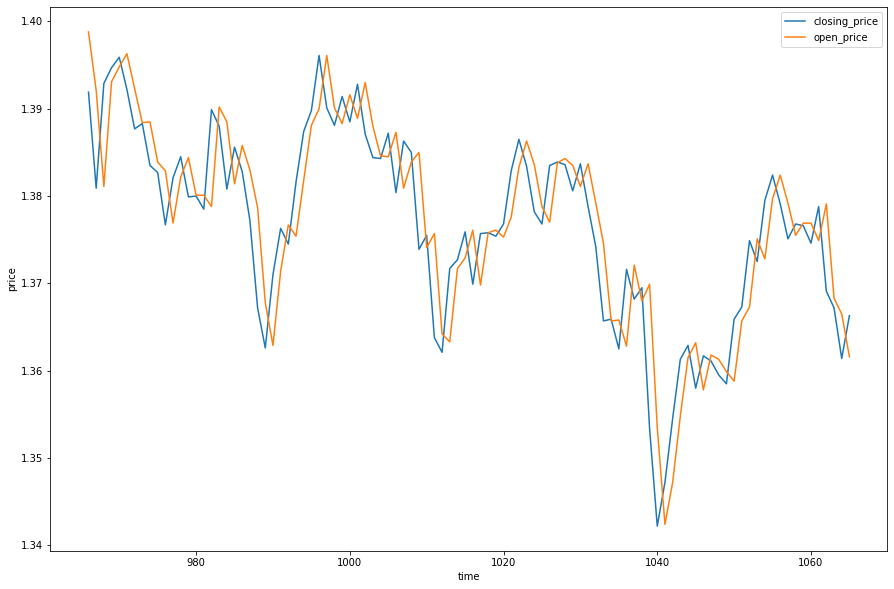

In [200]:
plt.figure(figsize=(15,10))
plt.plot(closing_price[len(closing_price)-100:],label='closing_price')
plt.xlabel('time')
plt.ylabel('price')
plt.plot(open_price[len(open_price)-100:],label='open_price')
plt.legend()

#### 特徴量として扱うテクニカル指標は以下のもの





*   SMA(単純移動平均線)､期間は20と50で設定する
*   MACD､期間は12と26で設定する
*   RSI､期間は7日､14日で設定する
*   WILLR､期間は14で設定する




In [ ]:
#SMA
sma20=talib.SMA(df['終値'],timeperiod=20)
sma50=talib.SMA(df['終値'],timeperiod=50)
#MACD
macd, macdsignal, macdhist = talib.MACD(df['終値'], fastperiod=12, slowperiod=26, signalperiod=9)
#RSi
rsi7=talib.RSI(df['終値'],timeperiod=7)
rsi14=talib.RSI(df['終値'],timeperiod=14)

In [ ]:
df['sma20']=sma20
df['sma50']=sma50
df['macd']=macd
df['rsi7']=rsi7
df['rsi14']=rsi14

In [ ]:
#sma50によって0:49の値はNaNになっているため
df=df[49:]

In [ ]:
closing_price=np.array(df['終値'])
open_price=np.array(df['始値'])
low_price=np.array(df['安値'])
high_price=np.array(df['高値'])
sma20=np.array(df['sma20'])
sma50=np.array(df['sma50'])
macd=np.array(df['macd'])
rsi7=np.array(df['rsi7'])
rsi14=np.array(df['rsi14'])

In [ ]:
def create_window(window_size,split):
  train=[]
  test=[]
  len_data=len(closing_price)
  for i in (range(len_data-window_size)):
    t=[]
    t.append(closing_price[i:i+window_size])
    t.append(open_price[i:i+window_size])
    t.append(low_price[i:i+window_size])
    t.append(high_price[i:i+window_size])
    t.append(sma20[i:i+window_size])
    t.append(sma50[i:i+window_size])
    t.append(macd[i:i+window_size])
    t.append(rsi7[i:i+window_size])
    t.append(rsi14[i:i+window_size])
    train.append(t)
    test.append(closing_price[i+window_size])
  x_train,x_test=train[:int(len_data*split)],train[int(len_data*split):]
  y_train,y_test=test[:int(len_data*split)],test[int(len_data*split):] 
  x_train=np.array(x_train)
  x_test=np.array(x_test)
  y_train=np.array(y_train)
  y_test=np.array(y_test) 
  return x_train,x_test,y_train,y_test

In [ ]:
x_train,x_test,y_train,y_test=create_window(30,0.9)

### 学習率の最適化
optimizerで何を使うかの選択
*   SGD
*   Adam
*   RAdam





　

In [ ]:
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
#SGDを使うなら
def lr_rate(epoch):
  x=0.1
  if 50<=epoch<100:
    x=0.01
  if 100<=epoch<150:
    x=0.001
  if 150<=epoch<200:
    x=0.0001
  if 200<=epoch<250:
    x=0.00001
  if 250<=epoch<300:
    x=0.000001
  return x
lr_decay = LearningRateScheduler(
    lr_rate,
    verbose=1,
    )
def create_LSTM_model():
    input = Input(shape=(np.array(x_train).shape[1], np.array(x_train).shape[2]))
    x = LSTM(128, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LSTM(64)(x)
    output = Dense(1, activation='linear')(x)
    model = Model(input, output)
    return model
model=create_LSTM_model()
model.summary()
model.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9), loss='mean_squared_error',)
history=model.fit(x_train,y_train,epochs=300,batch_size=32,callbacks=[lr_decay])

### 学習率変化の可視化

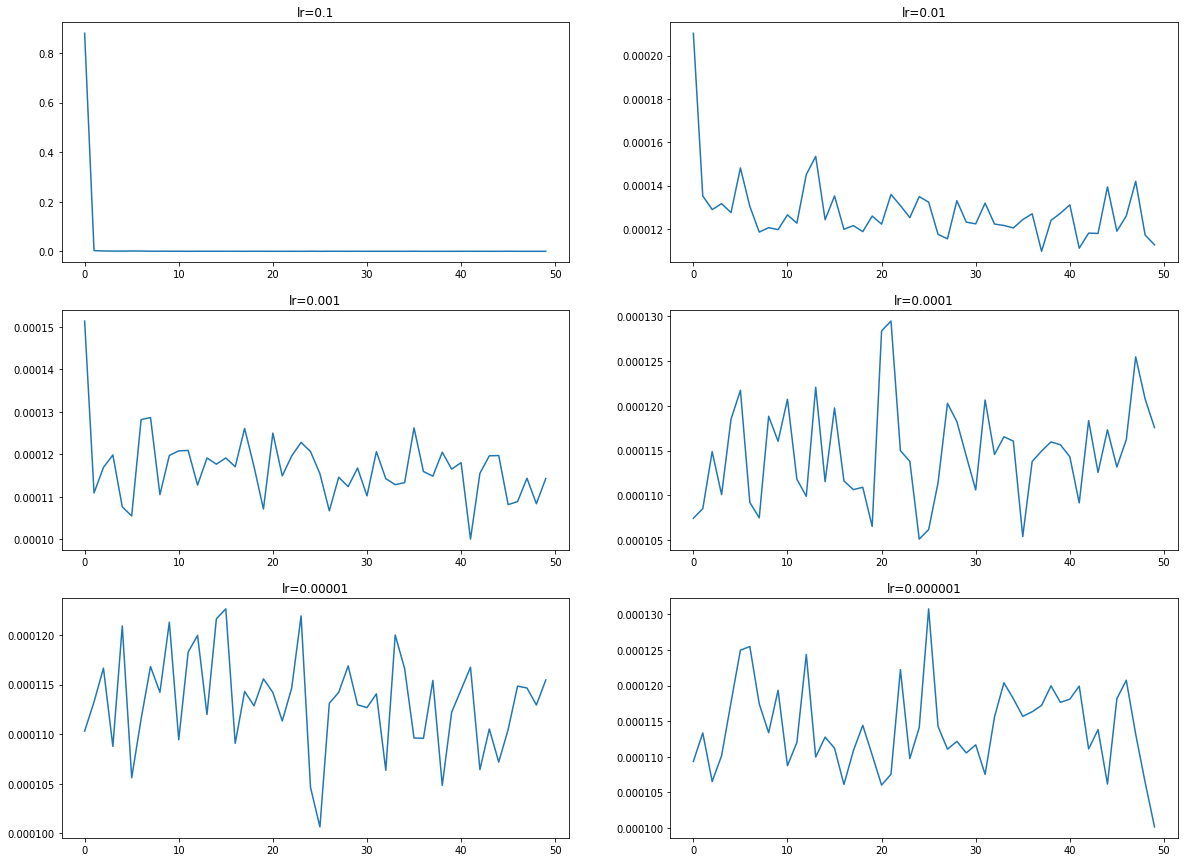

In [ ]:
loss_history=history.history['loss']
fig,ax=plt.subplots(3,2,figsize=(20,15))
ax[0][0].plot(loss_history[0:50])
ax[0][1].plot(loss_history[50:100])
ax[1][0].plot(loss_history[100:150])
ax[1][1].plot(loss_history[150:200])
ax[2][0].plot(loss_history[200:250])
ax[2][1].plot(loss_history[250:])
ax[0][0].set_title('lr=0.1')
ax[0][1].set_title('lr=0.01')
ax[1][0].set_title('lr=0.001')
ax[1][1].set_title('lr=0.0001')
ax[2][0].set_title('lr=0.00001')
ax[2][1].set_title('lr=0.000001')
plt.show()

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa
def create_LSTM_model():
    input = Input(shape=(np.array(x_train).shape[1], np.array(x_train).shape[2]))
    x = LSTM(128, return_sequences=True)(input)
    x = LSTM(64)(x)
    x = Dropout(0.25)(x)
    x = Dense(32)(x)
    output = Dense(1, activation='linear')(x)
    model = Model(input, output)
    return model
model=create_LSTM_model()
model.summary()
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.001,weight_decay=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error',)

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 9, 30)]           0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 9, 128)            81408     
_________________________________________________________________
lstm_87 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 33        
Total params: 132,929
Trainable params: 132,929
Non-trainable params: 0
____________________________________________________

In [ ]:
history=model.fit(x_train,y_train,epochs=300,batch_size=20)

In [ ]:
predict=model.predict(x_test)

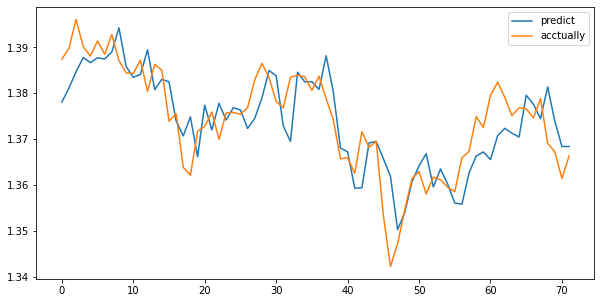

In [ ]:
import matplotlib.pyplot as plt
predict=model.predict(x_test)
plt.figure(figsize=(10,5))
plt.plot(predict,label='predict')
plt.plot(y_test,label='acctually')
plt.legend()